# Water potability example
https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

## Load dataset

In [1]:
import pandas as pd
 
# Read data
data = pd.read_csv("water_potability.csv")
#X = data.loc[:, ['ph', 'Sulfate', 'Conductivity', 'Organic_carbon']]
#y = data.loc[:, ['Potability']]
X = data.iloc[:, 0:9]
y = data.iloc[:, 9]

In [2]:
X.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.587349,0.577747,0.386298,0.568199,0.647347,0.292985,0.654522,0.795029,0.630115
1,0.643654,0.441300,0.314381,0.439304,0.514545,0.356685,0.377248,0.202914,0.520358
2,0.388934,0.470876,0.506122,0.524364,0.561537,0.142913,0.249922,0.401487,0.219973
3,0.725820,0.715942,0.506141,0.521683,0.751819,0.148683,0.467200,0.658678,0.242428
4,0.610517,0.532588,0.237701,0.270288,0.495155,0.494792,0.409721,0.469762,0.585049


In [3]:
from sklearn.preprocessing import LabelEncoder
 
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [4]:
encoder.classes_

array([0, 1])

In [5]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
import torch
 
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

## Create a model

In [55]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(9, 27)
        self.relu = nn.ReLU()
        self.output = nn.Linear(27, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [52]:
import torch.nn as nn
 
class Wide2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 27)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(27, 9)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [8]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 9)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(9, 9)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(9, 9)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

## Split data

In [9]:
from sklearn.model_selection import StratifiedKFold, train_test_split
 
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

## Cross-validation

In [57]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
 
def model_train(model, X_train, y_train, X_val, y_val, lr, momentum):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
 
    n_epochs = 50   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [ ]:
cv_results = pd.DataFrame(columns=["model", "lr", "momentum", "acc", "std"])
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

for lr in range(1, 4):
    lr = lr / 100
    for momentum in range(95, 100, 1):
        momentum = momentum / 100
        cv_scores = []
        for train, test in kfold.split(X_train, y_train):
            # create model, train, and get accuracy
            model = Wide()
            acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], lr, momentum)
            cv_scores.append(acc)
        mean_acc = np.mean(cv_scores)
        mean_std = np.std(cv_scores)
        print("Accuracy (lr: %f, momentum: %f): %.2f" % (lr, momentum, acc))
        cv_results = cv_results._append({"model": "wide", "lr": lr, "momentum": momentum, "acc": mean_acc, "std": mean_std}, ignore_index=True)

Accuracy (lr: 0.010000, momentum: 0.950000): 0.63


/tmp/ipykernel_1833/3146292128.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cv_results = cv_results._append({"model": "wide", "lr": lr, "momentum": momentum, "acc": mean_acc, "std": mean_std}, ignore_index=True)


Accuracy (lr: 0.010000, momentum: 0.960000): 0.67
Accuracy (lr: 0.010000, momentum: 0.970000): 0.68
Accuracy (lr: 0.010000, momentum: 0.980000): 0.62
Accuracy (lr: 0.010000, momentum: 0.990000): 0.59
Accuracy (lr: 0.020000, momentum: 0.950000): 0.71
Accuracy (lr: 0.020000, momentum: 0.960000): 0.67
Accuracy (lr: 0.020000, momentum: 0.970000): 0.64
Accuracy (lr: 0.020000, momentum: 0.980000): 0.64
Accuracy (lr: 0.020000, momentum: 0.990000): 0.59
Accuracy (lr: 0.030000, momentum: 0.950000): 0.66
Accuracy (lr: 0.030000, momentum: 0.960000): 0.70
Accuracy (lr: 0.030000, momentum: 0.970000): 0.60
Accuracy (lr: 0.030000, momentum: 0.980000): 0.59


In [45]:
cv_results

,model,lr,momentum,acc,std
0,wide,0.01,0.95,0.614071,0.019395
1,wide,0.01,0.96,0.627559,0.021299
2,wide,0.01,0.97,0.626140,0.027795
3,wide,0.01,0.98,0.622617,0.015251
4,wide,0.01,0.99,0.593473,0.007648
5,wide,0.02,0.95,0.629732,0.026124
6,wide,0.02,0.96,0.607680,0.016467
7,wide,0.02,0.97,0.607675,0.011147
8,wide,0.02,0.98,0.604149,0.017149
9,wide,0.02,0.99,0.585644,0.001372


In [35]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)
 
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Accuracy (wide): 0.62
Accuracy (wide): 0.61
Accuracy (wide): 0.60
Accuracy (wide): 0.60
Accuracy (wide): 0.61
Accuracy (deep): 0.60
Accuracy (deep): 0.60
Accuracy (deep): 0.60
Accuracy (deep): 0.60
Accuracy (deep): 0.60
Wide: 60.98% (+/- 0.77%)
Deep: 60.27% (+/- 0.13%)


## Retrain final model

In [36]:
# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a wide model
Final model accuracy: 58.28%


## Inference
Test inference by running 5 samples from test dataset

In [37]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[0.6038997  0.4425794  0.5538489  0.5252293  0.62891424 0.34848994
 0.32439744 0.6423755  0.17209034] -> [0.44304046] (expected [1.])
[0.37143406 0.5666278  0.7984294  0.44826794 0.4282795  0.5153674
 0.7047424  0.5368935  0.55305666] -> [0.4406165] (expected [0.])
[0.37275094 0.40116858 0.4342135  0.23806997 0.67555195 0.5238844
 0.52093464 0.21263182 0.07186264] -> [0.4494966] (expected [1.])
[0.43026826 0.67111075 0.3868964  0.5708546  0.50347656 0.5138064
 0.5996468  0.42912808 0.5114898 ] -> [0.44142717] (expected [0.])
[0.49821636 0.43287015 0.36933523 0.5181217  0.70669425 0.67054635
 0.42017284 0.6642019  0.35998395] -> [0.44956693] (expected [1.])


## ROC
Receiver operating characteristics curve

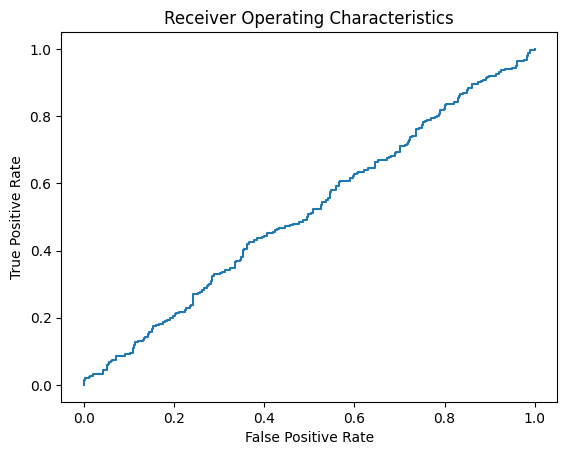

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
 
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()